Goal: Implement MDOCA (quick method for finding optimal parameters in Turing eqns) from Garvie 2010.

Will start with kinetics i) (Schnakenberg) in 1D.

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
def step_ae(p, q,):
    """
    Steps Lagrange multipliers p and q backwards in time
    according to the adjoint equations (AE).
    """
    
    # solution of semi-implicit equation (12)
    
    
    return p, q


def step_sgu(c1, c2,):
    """
    Steps constants c1 and c2 in the direction that decreases
    J, according to the standard gradient update (SGU).
    """
    
    return c1, c2

def eval_j(u, v, ut, vt, c1, c2, g1, g2, d1, d2):
    """
    Evaluates the objective functional J.
    """
    
    j = np.sum(g1*(u-ut)**2 + g2*(v-vt)**2)*dx + d1*c1**2 + d2*c2**2 
    j*= 0.5
    
    return j


## Forward Problem

GMRES for semi implicit DE

In [6]:
import scipy.sparse as sp

def step_se(u, v, a, b, nsteps=1):
    """
    Steps morphogen concentrations u and v forwards in time
    according to the system equations (SE).
    """
    
    for i in range(nsteps):
        # nonlinear reaction terms
        # for u: u(n)*u(n+1)*v(n)
        u_nonlin = sp.eye(nx)
        u_nonlin.setdiag(u*v)

        # for v: u(n)^2*v(n+1)
        v_nonlin = sp.eye(nx)
        v_nonlin.setdiag(u**2)


        # linear operators for gmres
        A_u = iden - dt*( du*lap - g*iden + g*u_nonlin )
        b_u = u + dt*g*a

        A_v = iden - dt*( dv*lap - g*v_nonlin )
        b_v = v + dt*g*b


        # Run GMRES to solve for next timestep
        u, info_u = sp.linalg.gmres(A_u, b_u)
        v, info_v = sp.linalg.gmres(A_v, b_v)
        
        # Should catch a convergence failure here using info_u and info_v

    return u, v

nx = 25
du = 1
dv = 10
g = 1000
a = 0.126779*0.25
b = .792366
dt = 0.0001
dx = 0.05

# initialize near steady-state solution
u = np.ones(nx)*(a+b)
u[4] *= 1.1 # perturbation to test
v = np.ones(nx)*(b/(a+b)**2)

# finite difference for laplacian
# boundaries currently periodic 
lap = sp.diags([-2,1,1,1,1], offsets=[0,1,-1,nx-1,1-nx], shape=(nx,nx)) / dx**2

# identity matrix
iden = sp.eye(nx)


# integrate over time, solving using GMRES at each timestep
niter = 1000

u_stored = np.zeros((nx, niter+1))
u_stored[:,0] = u

v_stored = np.zeros((nx, niter+1))
v_stored[:,0] = v

for i in range(niter):
    # Run GMRES to solve for next timestep
    u, v = step_se(u,v, a,b)

    # store for later animation
    u_stored[:,i+1] = u
    v_stored[:,i+1] = v

# plt.show()
# print(u, info)

In [7]:
from animation import animate_2d_array

animate_2d_array(u_stored[:,::10], interval=1)

# plt.plot(u_stored[:,-1])

In [5]:
# animate_2d_array(v_stored[:,::100], interval=1)

1D Forward Problem seems to work well; we see a finite-wavelength instability for certain parameters.

## Inverse Problem

Now try MDOCA for this 1D case. 

In [6]:
# parameters
nx = 25
du = 1
dv = 10
g = 1000
a = 0.126779*0.25
b = .792366
dt = 0.0001
dx = 0.05

g1, g2 = 1e10, 1e10
d1, d2 = 1, 1

In [7]:

# use steady-state of previous forward problem solution as target function
u_t, v_t = u_stored[:,-1], v_stored[:,-1]

# iteration parameters
l = 1e-5
niter = 500
jtol = 100
ltol = 1e-5 # curently unused
c1, c2 = a*1e3, b*1 # initial guess


def descend_c(u_t, v_t, c1, c2, l, jtol):
    '''Find optimal c1, c2 by descending gradient of J'''
    
    # solve SE for one step, starting at target
    u1, v1 = step_se(u_t, v_t, c1, c2)

    # evaluate cost after this timestep
    j1 = eval_j(u1, v1, u_t, v_t, c1, c2, g1, g2, d1, d2)


    for i in range(niter):

        # step c1, c2 and evaluate cost gradient
        increment = 1e-6
        c1s, c2s = c1+increment, c2+increment

        u1s1, v1s1 = step_se(u_t, v_t, c1s, c2)
        u1s2, v1s2 = step_se(u_t, v_t, c1, c2s)

        j1s1 = eval_j(u1s1, v1s1, u_t, v_t, c1s, c2, g1, g2, d1, d2)
        j1s2 = eval_j(u1s2, v1s2, u_t, v_t, c1, c2s, g1, g2, d1, d2)

        jgrad = ((j1s1-j1)/increment, (j1s2-j1)/increment)

        # step both in direction opposite to gradient
        c1_new = c1-l*jgrad[0]
        c2_new = c2-l*jgrad[1]

        # test whether j actually decreased;
        # if not then change step size and do again
        # if yes then update c1, c2

        u1_new, v1_new = step_se(u_t, v_t, c1_new, c2_new)
        j1_new = eval_j(u1_new, v1_new, u_t, v_t, c1_new, c2_new, g1, g2, d1, d2)

        if j1_new > j1:
            l /= 10

        else:
            l *= 3/2
            c1, c2 = c1_new, c2_new
            u1, u2 = u1_new, v1_new
            j1 = j1_new


        if j1_new < jtol:
            # plt.plot(u1_new)
            print('convergence to optimal solution reached in {} iterations'.format(i))
            break

        if i==niter-1: 
            # plt.plot(u1_new)
            print(j1)
            print('failed to converge after {} iterations'.format(niter))

    return c1, c2

c1, c2 = descend_c(u_t, v_t, c1, c2, l, jtol)

print(a - c1)
print(b - c2)

# plt.plot(u_t, 'k.')
# plt.show()

convergence to optimal solution reached in 16 iterations
-0.0001370611714986078
-5.911347417320023e-05


Now try 2D. Laplacian is a bit harder to handle, and we'll need a larger space loop. 
Could handle Laplacian by unraveling arrays; normally would be a rank-4 tensor, unraveling can convert to rank two.

In [8]:
# testing 2d laplacian as sparse array
import scipy.sparse as sp

# using finite difference method over grid
# should also look into mesh method
nx, ny = 10, 10

lap = np.zeros((nx, ny, nx, ny))

for k in range(nx):
    for l in range(ny):
        
        lap[(k+1)%nx, l, k, l] = 1
        lap[(k-1)%nx, l, k, l] = 1
        
        lap[k, (l+1)%ny, k, l] = 1
        lap[k, (l-1)%ny, k, l] = 1
        
        lap[k, l, k, l] = -4
        
lap_2d = lap.reshape(nx*ny, nx*ny)
        
inp = np.zeros((nx,ny))
inp[-1,0] += 1

inp_1d = inp.reshape(nx*ny)


# out = np.einsum('ijkl,kl->ij', lap, inp)

out_1d = lap_2d @ inp_1d

out = out_1d.reshape(nx,ny)

# plt.imshow(out)
# plt.colorbar()
# plt.show()
        
# this seems to work well, now let's try using it to do the 2d forward problem.

lap_sp = sp.csr_matrix(lap_2d)

# print(lap_sp)

In [78]:
# 2d forward problem

def step_se_2d(u, v, a, b, nsteps=1):
    """
    Steps morphogen concentrations u and v forwards in time
    according to the system equations (SE).
    """

    for step in range(nsteps):
        # nonlinear reaction terms
        # for u: u(n)*u(n+1)*v(n)
        u_nonlin = sp.eye(nx*ny)
        u_nonlin.setdiag(u*v)

        # for v: u(n)^2*v(n+1)
        v_nonlin = sp.eye(nx*ny)
        v_nonlin.setdiag(u**2)


        # linear operators for gmres
        A_u = iden - dt*( du*lap - g*iden + g*u_nonlin )
        b_u = u + dt*g*a

        A_v = iden - dt*( dv*lap - g*v_nonlin )
        b_v = v + dt*g*b


        # Run GMRES to solve for next timestep
        u, info_u = sp.linalg.gmres(A_u, b_u, maxiter=1000)
        v, info_v = sp.linalg.gmres(A_v, b_v, maxiter=1000)
        
        # Should catch a convergence failure here using info_u and info_v
        if info_u>0 or info_v>0:
            print("Warning: GMRES convergence failed")

    return u, v

# spots params
nx = 50
ny = 50
du = 1
dv = 10
g = 1000
a = 0.126779 * 0.25
b = 1.1
dt = 0.0001
dx = 0.05

# # stripes params
# g = 10
# dv = 5

# a = (3.6-3.1)/2
# b = (3.6+3.1)/2

# initialize near steady-state solution
# all matrices are unraveled
u = np.ones(nx*ny)*(a+b)
# u[int(nx*ny/4)] *= 1.1 # perturbation to test
u += np.random.normal(scale=.1, size=nx*ny) # white noise to test
v = np.ones(nx*ny)*(b/(a+b)**2)

# finite difference for laplacian
# boundaries currently periodic 
lap = np.zeros((nx, ny, nx, ny))

for k in range(nx):
    for l in range(ny):

        lap[(k+1)%nx, l, k, l] = 1
        lap[(k-1)%nx, l, k, l] = 1

        lap[k, (l+1)%ny, k, l] = 1
        lap[k, (l-1)%ny, k, l] = 1

        lap[k, l, k, l] = -4

lap_2d = lap.reshape(nx*ny, nx*ny)
lap = sp.csr_matrix(lap_2d)/dx**2


# identity matrix
iden = sp.eye(nx*ny)


# integrate over time, solving using GMRES at each timestep
niter = 1000

u_stored = np.zeros((nx*ny, niter+1))
u_stored[:,0] = u

v_stored = np.zeros((nx*ny, niter+1))
v_stored[:,0] = v

for i in range(niter):
    # if i%100==1: print(i-1)
    # Run GMRES to solve for next timestep
    u, v = step_se_2d(u,v, a,b)

    # store for later animation
    u_stored[:,i+1] = u
    v_stored[:,i+1] = v

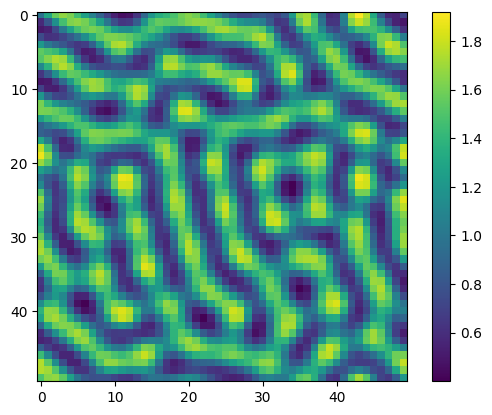

In [79]:
# Reshape arrays for plotting
u_stored_2d = u_stored.reshape(nx, ny, niter+1)
plt.imshow(u_stored_2d[:,:,-1])
plt.colorbar()
plt.show()
# print(u, info)

In [80]:
from animation import animate_3d_function_small

animate_3d_function_small(u_stored_2d, interval=100)

Now try 2d inverse problem via MDOCA. Should be pretty much the same as 1d after flattening.

Maybe I don't even need a new function.

In [12]:
# parameters
g1, g2 = 1e10, 1e10
d1, d2 = 1, 1

In [14]:

# use steady-state of previous forward problem solution as target function
u_t, v_t = u_stored[:,-1], v_stored[:,-1]

# iteration parameters
l = 1e-2
niter = 500
jtol = 1e5
ltol = 1e-5 # curently unused
c1, c2 = a*2, b*2 # initial guess


def descend_c_2d(u_t, v_t, c1, c2, l, jtol):
    '''Find optimal c1, c2 by descending gradient of J'''
    
    # solve SE for one step, starting at target
    u1, v1 = step_se_2d(u_t, v_t, c1, c2)

    # evaluate cost after this timestep
    j1 = eval_j(u1, v1, u_t, v_t, c1, c2, g1, g2, d1, d2)


    for i in range(niter):

        # step c1, c2 and evaluate cost gradient
        increment = 1e-6
        c1s, c2s = c1+increment, c2+increment

        u1s1, v1s1 = step_se_2d(u_t, v_t, c1s, c2)
        u1s2, v1s2 = step_se_2d(u_t, v_t, c1, c2s)

        j1s1 = eval_j(u1s1, v1s1, u_t, v_t, c1s, c2, g1, g2, d1, d2)
        j1s2 = eval_j(u1s2, v1s2, u_t, v_t, c1, c2s, g1, g2, d1, d2)

        jgrad = ((j1s1-j1)/increment, (j1s2-j1)/increment)

        # step both in direction opposite to gradient
        c1_new = c1-l*jgrad[0]
        c2_new = c2-l*jgrad[1]

        # test whether j actually decreased;
        # if not then change step size and do again
        # if yes then update c1, c2

        u1_new, v1_new = step_se_2d(u_t, v_t, c1_new, c2_new)
        j1_new = eval_j(u1_new, v1_new, u_t, v_t, c1_new, c2_new, g1, g2, d1, d2)
        
        print(j1,j1_new)

        if j1_new > j1:
            l /= 10

        else:
            l *= 3/2
            c1, c2 = c1_new, c2_new
            u1, u2 = u1_new, v1_new
            j1 = j1_new


        if j1 < jtol:
            # plt.plot(u1_new)
            print('convergence to optimal solution reached in {} iterations'.format(i))
            break

        if i==niter-1: 
            # plt.plot(u1_new)
            print(j1)
            print('failed to converge after {} iterations'.format(niter))

    return c1, c2

c1, c2 = descend_c_2d(u_t, v_t, c1, c2, l, jtol)

print(a - c1)
print(b - c2)

# plt.plot(u_t, 'k.')
# plt.show()

3310456428.099467 3.669830300539999e+25
3310456428.099467 3.66982967316141e+23
3310456428.099467 3.6698233993784795e+21
3310456428.099467 3.6697606618441437e+19
3310456428.099467 3.669133315996399e+17
3310456428.099467 3662862807073242.0
3310456428.099467 36004526771562.71
3310456428.099467 300584796241.5712
3310456428.099467 9415420.959357526
9415420.959357526 3248208.5756477034
3248208.5756477034 6153801.804928323
3248208.5756477034 1908171.3728180942
1908171.3728180942 820337.7886020931
820337.7886020931 219033.85170101596
219033.85170101596 59654.81087456649
convergence to optimal solution reached in 14 iterations
-8.186885177177e-05
-0.0011125579065273117


Seems to work!

Next goal is to get all these working on a mesh (use mesh laplacian?).